<h1>TKN Training Notebook</h1>
This notebook is used to train the network

In [1]:
import torch
import torch.nn as nn
import numpy as np
import time
import math
import pandas as pd
import os, datetime

from matplotlib import pyplot
pyplot.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

<h2>Data Processing</h2>

In [2]:
def get_data():
    time        = np.arange(0, 1600, 0.1)
    amplitude   = np.sin(time*.5) + .2*np.sin(time*.02) + .1 * np.sin(time*0.12) *np.random.normal(-0.2, 0.2, len(time))
    #amplitude = np.sin(time*0.5) 
    
    #from pandas import read_csv
    #series = read_csv('daily-min-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler(feature_range=(-1, 1)) 
    #amplitude = scaler.fit_transform(series.to_numpy().reshape(-1, 1)).reshape(-1)
    amplitude = scaler.fit_transform(amplitude.reshape(-1, 1)).reshape(-1)

    return amplitude

In [3]:
df = get_data()
df = np.array(df).reshape((-1,1))
print(df.shape)

(16000, 1)


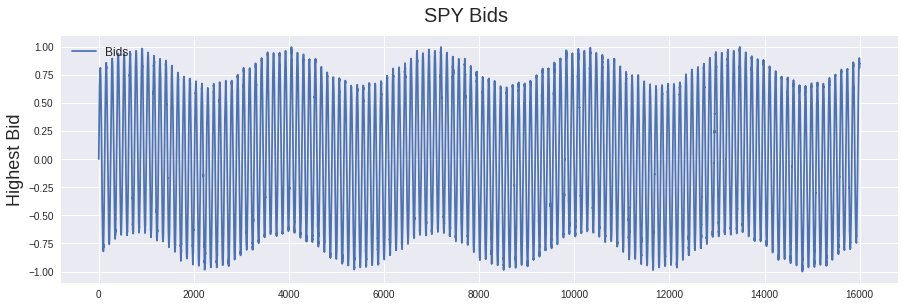

In [4]:
fig = pyplot.figure(figsize=(15,10))
st = fig.suptitle("SPY Bids", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df, label='Bids')
ax1.set_ylabel('Highest Bid', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

<h2>Model, Optimizer, and Criterion</h2>

In [5]:
import tkn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('cuda' if torch.cuda.is_available() else 'cpu')

INPUT_DIM = df.shape[1]

# TODO: AFTER UNCERTAINTY IS IMPLEMENTED, UNCOMMENT
#OUTPUT_DIM = INPUT_DIM * 2
OUTPUT_DIM = INPUT_DIM

# HID_DIM = 256
# ENC_LAYERS = 2
# DEC_LAYERS = 2
# ENC_HEADS = 8
# DEC_HEADS = 8
# ENC_PF_DIM = 512
# DEC_PF_DIM = 512
# ENC_DROPOUT = 0.1
# DEC_DROPOUT = 0.1

# MAX_IN = 128
# MAX_OUT = 128

HID_DIM = 128
ENC_LAYERS = 2
DEC_LAYERS = 2
ENC_HEADS = 4
DEC_HEADS = 4
ENC_PF_DIM = 128
DEC_PF_DIM = 128
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

PENC_LAYERS_IN = 1
PENC_LAYERS_OUT = 1

MAX_IN = 64
MAX_OUT = 32

enc = tkn.Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device, max_length=MAX_IN,
              penc_layers=PENC_LAYERS_IN)

dec = tkn.Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device, max_length=MAX_OUT,
              penc_layers=PENC_LAYERS_OUT)

cuda


In [6]:
#TODO: CHANGE PAD value
SRC_PAD = [9 for _ in range(INPUT_DIM)]
TRG_PAD = [9 for _ in range(OUTPUT_DIM)]

SRC_PAD_IDX = torch.FloatTensor(SRC_PAD).to(device)
TRG_PAD_IDX = torch.FloatTensor(OUTPUT_DIM).to(device)

In [7]:
model = tkn.TKN(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [8]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 543,873 trainable parameters


In [9]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        #nn.init.xavier_uniform_(m.weight.data,gain=.1)
        torch.nn.init.normal_(m.weight, mean=0.0, std=1.0)
model.apply(initialize_weights);

In [10]:
LEARNING_RATE = 0.005

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=.95,patience=8,min_lr=1e-7)

# TODO: create custom criterion
criterion = nn.MSELoss()

<h2>Batch Generation</h2>

In [11]:
from random import random

#TODO: generate variable length sequences
def gen_loader(data, batch_size, in_len, out_len, device, prop=.4):
    inps = []
    tgts = []
    
    for i in range(len(data) - in_len - out_len + 1):
        if (random() <= prop):
            inps.append(data[i:i+in_len])
            # TODO: add target uncertainty
            tgts.append(np.concatenate(([TRG_PAD], data[i+in_len-1:i+in_len+out_len-1]),axis=0))
        
    # TODO: set device to cpu because more RAM is available
    inps = torch.FloatTensor(inps).to(device)
    tgts = torch.FloatTensor(tgts).to(device)
    
    dataset = torch.utils.data.TensorDataset(inps, tgts)
    
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [12]:
def train(model, loader, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    total = 0
    
    for i, data in enumerate(loader):
        inp = data[0]
        tgt = data[1]
        
        optimizer.zero_grad()
        
        output = model(inp, tgt[:,:-1])
        
#         output = output.contiguous().view(-1, OUTPUT_DIM)
        tgt = tgt[:,1:]
#         tgt = tgt[:,1:].contiguous().view(-1)
        
        loss = criterion(output, tgt)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        total = i
        
    return epoch_loss / total



def evaluate(model, loader, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    total = 0
    
    with torch.no_grad():
    
        for i, data in enumerate(loader):
            inp = data[0]
            tgt = data[1]
            
            output = model(inp, tgt[:,:-1])
        
            loss = criterion(output, tgt[:,1:])

            epoch_loss += loss.item()
            
            total = i
        
    return epoch_loss / total

In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [14]:
TRAIN_RATIO = .8
BATCH_SIZE = 64

T_INDEX = math.ceil(TRAIN_RATIO * len(df))

tdf = df[:T_INDEX]
vdf = df[T_INDEX:]

train_iterator = gen_loader(tdf, BATCH_SIZE, MAX_IN, MAX_OUT, device, prop=1)
valid_iterator = gen_loader(vdf, BATCH_SIZE, MAX_IN, MAX_OUT, device, prop=1)

In [15]:
PRELOAD = False

if PRELOAD:
    model.load_state_dict(torch.load('tkn-model.pt'))

In [16]:
N_EPOCHS = 16000
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tkn-model.pt')
    
    temp_lr = [ group['lr'] for group in optimizer.param_groups]
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s | lr: {temp_lr[0]:.5f}')
    print(f'\tTrain Loss: {train_loss:.5f} | Train PPL: {math.exp(train_loss):7.5f}')
    print(f'\t Val. Loss: {valid_loss:.5f} |  Val. PPL: {math.exp(valid_loss):7.5f}')
    
    scheduler.step(valid_loss)

Epoch: 01 | Time: 0m 5s | lr: 0.00500
	Train Loss: 9.06836 | Train PPL: 8676.36669
	 Val. Loss: 1.04211 |  Val. PPL: 2.83519
Epoch: 02 | Time: 0m 5s | lr: 0.00500
	Train Loss: 0.48398 | Train PPL: 1.62251
	 Val. Loss: 0.30443 |  Val. PPL: 1.35585
Epoch: 03 | Time: 0m 5s | lr: 0.00500
	Train Loss: 0.35112 | Train PPL: 1.42066
	 Val. Loss: 0.29198 |  Val. PPL: 1.33908
Epoch: 04 | Time: 0m 5s | lr: 0.00500
	Train Loss: 0.30804 | Train PPL: 1.36076
	 Val. Loss: 0.32765 |  Val. PPL: 1.38770
Epoch: 05 | Time: 0m 5s | lr: 0.00500
	Train Loss: 0.31519 | Train PPL: 1.37052
	 Val. Loss: 0.27929 |  Val. PPL: 1.32219
Epoch: 06 | Time: 0m 5s | lr: 0.00500
	Train Loss: 0.28648 | Train PPL: 1.33173
	 Val. Loss: 0.24819 |  Val. PPL: 1.28171
Epoch: 07 | Time: 0m 5s | lr: 0.00500
	Train Loss: 0.28837 | Train PPL: 1.33425
	 Val. Loss: 0.29624 |  Val. PPL: 1.34479
Epoch: 08 | Time: 0m 5s | lr: 0.00500
	Train Loss: 0.29099 | Train PPL: 1.33775
	 Val. Loss: 0.26111 |  Val. PPL: 1.29837
Epoch: 09 | Time: 0m 

Epoch: 69 | Time: 0m 5s | lr: 0.00320
	Train Loss: 0.08811 | Train PPL: 1.09211
	 Val. Loss: 0.08917 |  Val. PPL: 1.09326
Epoch: 70 | Time: 0m 5s | lr: 0.00256
	Train Loss: 0.08717 | Train PPL: 1.09108
	 Val. Loss: 0.09204 |  Val. PPL: 1.09640
Epoch: 71 | Time: 0m 5s | lr: 0.00256
	Train Loss: 0.08724 | Train PPL: 1.09116
	 Val. Loss: 0.09804 |  Val. PPL: 1.10301
Epoch: 72 | Time: 0m 5s | lr: 0.00256
	Train Loss: 0.08673 | Train PPL: 1.09060
	 Val. Loss: 0.08445 |  Val. PPL: 1.08812
Epoch: 73 | Time: 0m 5s | lr: 0.00256
	Train Loss: 0.08688 | Train PPL: 1.09076
	 Val. Loss: 0.08863 |  Val. PPL: 1.09268
Epoch: 74 | Time: 0m 5s | lr: 0.00256
	Train Loss: 0.08678 | Train PPL: 1.09065
	 Val. Loss: 0.08169 |  Val. PPL: 1.08512
Epoch: 75 | Time: 0m 5s | lr: 0.00256
	Train Loss: 0.08632 | Train PPL: 1.09015
	 Val. Loss: 0.08377 |  Val. PPL: 1.08738
Epoch: 76 | Time: 0m 5s | lr: 0.00256
	Train Loss: 0.08557 | Train PPL: 1.08934
	 Val. Loss: 0.08795 |  Val. PPL: 1.09194
Epoch: 77 | Time: 0m 5s 

KeyboardInterrupt: 

In [17]:
model.load_state_dict(torch.load('tkn-model.pt'))

# TODO: change valid to test iterator
test_loss = evaluate(model, valid_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.076 | Test PPL:   1.079 |


In [18]:
def predict_seq(src_tensor, model, device, max_len = MAX_OUT, start_vec=None):
    
    model.eval()
    
    #src_tensor = torch.reshape(src_tensor, (1,src_tensor.shape[0],-1))
    src_tensor = src_tensor.unsqueeze(0)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    if start_vec is not None:
        out_seq = start_vec.unsqueeze(0).unsqueeze(0)
    else:
        out_seq = TRG_PAD_IDX.unsqueeze(0).unsqueeze(0)
    
    for i in range(max_len):
        trg_mask = model.make_trg_mask(out_seq)
        
        with torch.no_grad():
            output = model.decoder(out_seq, enc_src, trg_mask, src_mask)
        pred = output[:,-1,:].unsqueeze(0)
        out_seq = torch.cat((out_seq, pred), 1)
    
    return out_seq

In [ ]:
# TODO: display attention

In [25]:
start = math.floor(random() * (len(df) - MAX_IN - MAX_OUT))

ex_seq = df[start:start+(MAX_IN+MAX_OUT)]

ex_inps = torch.FloatTensor(ex_seq[:MAX_IN]).to(device)

In [26]:
pred = predict_seq(ex_inps, model, device)

pred = pred[0].cpu().numpy()
pred = pred[1:]

print(f'predicted trg = {pred}')

predicted trg = [[0.4350063 ]
 [0.4350062 ]
 [0.4350062 ]
 [0.4350062 ]
 [0.43500626]
 [0.4350062 ]
 [0.43500623]
 [0.43500626]
 [0.43500626]
 [0.4350062 ]
 [0.4350062 ]
 [0.4350062 ]
 [0.43500626]
 [0.4350062 ]
 [0.4350062 ]
 [0.43500617]
 [0.43500617]
 [0.43500617]
 [0.43500617]
 [0.43500623]
 [0.43500617]
 [0.43500614]
 [0.43500626]
 [0.43500617]
 [0.43500617]
 [0.43500617]
 [0.43500617]
 [0.4350062 ]
 [0.43500617]
 [0.43500623]
 [0.43500623]
 [0.43500617]]


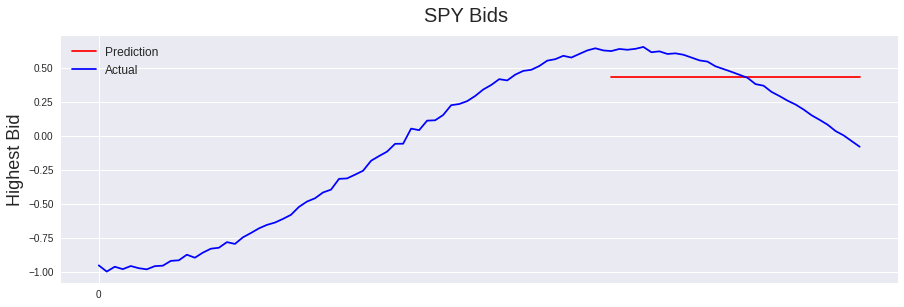

In [27]:
fig = pyplot.figure(figsize=(15,10))
st = fig.suptitle("SPY Bids", fontsize=20)
st.set_y(0.92)
ax1 = fig.add_subplot(211)
ax1.plot(np.arange(MAX_IN, ex_seq.shape[0]),pred[:,0], color='red', label='Prediction')
ax1.plot(np.arange(0, ex_seq.shape[0]),ex_seq[:,0], color='blue', label='Actual')
ax1.set_xticks(range(0, pred.shape[0], 1464))
ax1.set_ylabel('Highest Bid', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)